This notebook runs the capacitated vehicle routing problem for our base case scenario

In [1]:
pip install ortools

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install routing

In [7]:
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [8]:
"""Capacited Vehicles Routing Problem (CVRP)."""

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [  
        [
            0, 321, 791, 743, 492, 644, 618, 513, 822, 656, 596, 735, 773, 529, 372, 834
        ], 
        [
            321, 0, 422, 662, 266, 418, 500, 683, 992, 1127, 1188, 963, 1021, 303, 194, 608
        ], 
        [
            647, 471, 0, 991, 380, 147, 865, 1048, 1357, 1247, 1308, 1083, 1485, 774, 314, 638
        ], 
        [
            344, 666, 1135, 0, 613, 988, 449, 410, 592, 996, 903, 936, 748, 362, 676, 490
        ], 
        [
            492, 266, 592, 609, 0, 377, 670, 853, 1162, 1393, 1454, 1229, 1119, 251, 461, 342
        ],
        [
            540, 324, 147, 844, 377, 0, 718, 901, 1210, 1100, 1161, 936, 1338, 627, 167, 635
        ], 
        [
            218, 500, 1009, 453, 670, 862, 0, 183, 492, 769, 676, 709, 521, 573, 551, 942
        ], 
        [
            401, 683, 1192, 410, 853, 1045, 183, 0, 309, 726, 634, 667, 478, 530, 734, 899
        ], 
        [
            710, 992, 1501, 592, 1162, 1354, 492, 309, 0, 842, 741, 637, 235, 839, 1043, 943
        ], 
        [
            973, 1255, 1303, 982, 1353, 1156, 755, 712, 683, 0, 123, 608, 448, 1102, 989, 1471
        ],
        [
            596, 917, 1372, 903, 1274, 1225, 676, 634, 604, 430, 0, 225, 369, 1023, 1058, 1393
        ], 
        [
            493, 814, 1083, 936, 1307, 936, 709, 667, 637, 204, 225, 0, 402, 1056, 768, 1426
        ], 
        [
            768, 1049, 1485, 776, 1147, 1338, 549, 507, 235, 607, 505, 402, 0, 896, 1170, 1266
        ], 
        [
            464, 303, 629, 362, 251, 627, 573, 530, 839, 1115, 1023, 1056, 868, 0, 498, 369
        ], 
        [
            372, 519, 314, 676, 690, 167, 551, 734, 1043, 932, 994, 768, 1170, 727, 0, 802
        ], 
        [
            834, 608, 638, 490, 342, 635, 942, 899, 943, 1485, 1393, 1426, 1237, 369, 802, 0
        ],
    ]
    data['demands'] = [0, 24.398934 , 32.813974, 28.080347, 13.514304, 41.930230, 45.014770,
                       11.958897, 10.562819, 32.553647, 7.430177, 40.207492, 29.699453, 
                       72.657881, 27.079007, 29.233375]
    data['vehicle_capacities'] = [300, 300]
    data['num_vehicles'] = 2
    data['depot'] = 0
    return data


Demands: Each location has a demand corresponding to the quantity—for example, weight or volume—of the item to be picked up.
- Capacities: Each vehicle has a capacity: the maximum quantity that the vehicle can hold. As a vehicle travels along its route, the total quantity of the items it is carrying can never exceed its capacity.

In [9]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))



In [10]:
def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)
    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
    
    # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()

Route for vehicle 0:
 0 Load(0) ->  6 Load(45.01477) ->  7 Load(56.973667) ->  8 Load(67.536486) ->  12 Load(97.235939) ->  11 Load(137.443431) ->  9 Load(169.997078) ->  10 Load(177.42725499999997) ->  0 Load(177.42725499999997)
Distance of the route: 2670m
Load of the route: 177.42725499999997

Route for vehicle 1:
 0 Load(0) ->  1 Load(24.398934) ->  14 Load(51.477941) ->  5 Load(93.40817100000001) ->  2 Load(126.22214500000001) ->  4 Load(139.73644900000002) ->  15 Load(168.96982400000002) ->  13 Load(241.62770500000002) ->  3 Load(269.708052) ->  0 Load(269.708052)
Distance of the route: 2626m
Load of the route: 269.708052

Total distance of all routes: 5296m
Total load of all routes: 447.135307


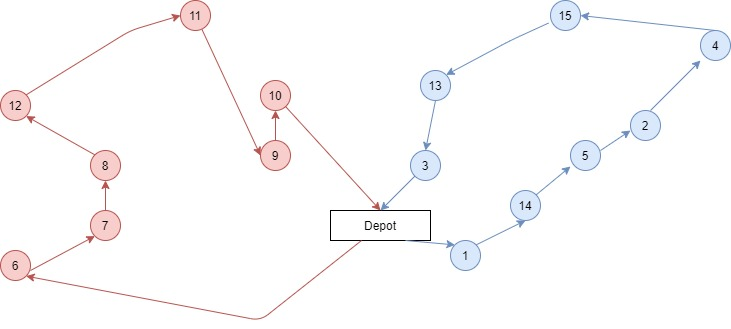